# Final project on Detection of Underwater Trash Work-in-progress
 - Group 4

### Project Selection & Setup

In [30]:
# Import required libraries
import os
import json
import cv2
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt


# Define paths to dataset folders
dataset_path = "dataset/original_data"
images_path = os.path.join(dataset_path, "images")
annotations_path = os.path.join(dataset_path, "annotations")
yolo_labels_path = "dataset/labels"

# Ensure paths exist
assert os.path.exists(images_path), f"Images path {images_path} does not exist!"
assert os.path.exists(annotations_path), f"Annotations path {annotations_path} does not exist!"
os.makedirs(yolo_labels_path, exist_ok=True)  # Create labels directory if it doesn't exist

### EDA and Pre-Processing

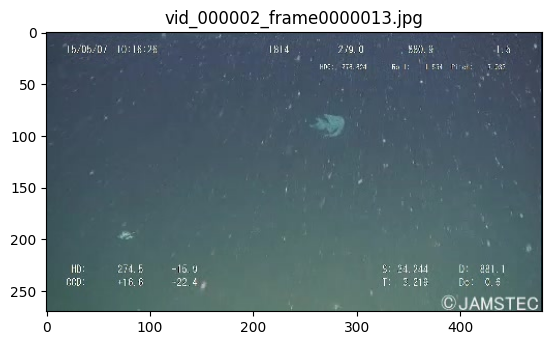

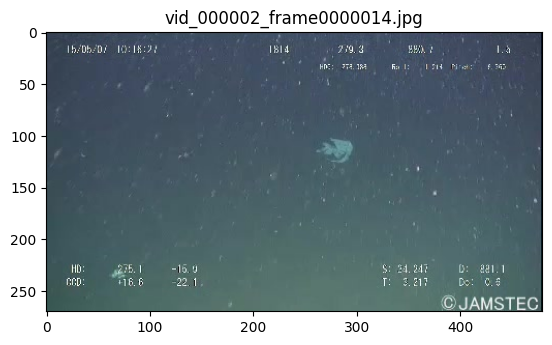

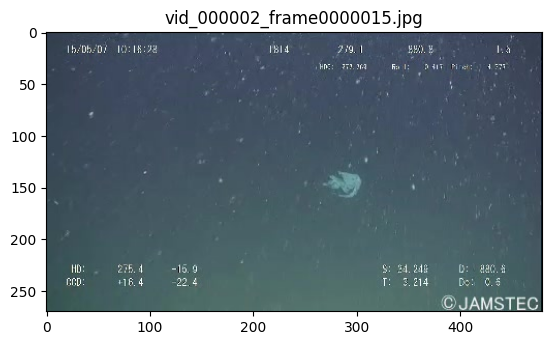

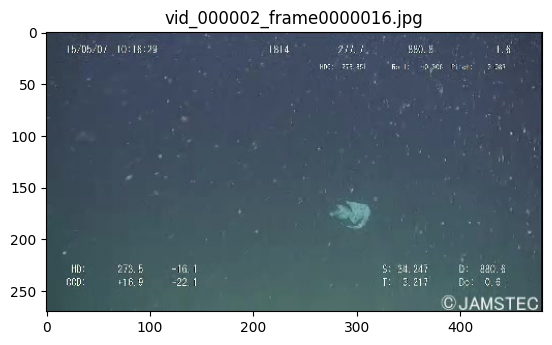

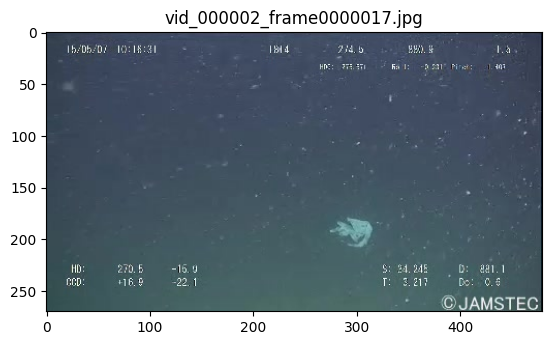

In [22]:
# Visualize a few sample images
sample_images = os.listdir(images_path)[:5]
for img_name in sample_images:
    img = cv2.imread(os.path.join(images_path, img_name))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(img_name)
    plt.show()

### Fallback Parsing Function

In [51]:
def parse_json_annotations_fallback(json_file):
    """
    Parse JSON annotations to extract bounding boxes using `origin` and fallback dimensions.
    """
    with open(json_file, 'r') as file:
        data = json.load(file)

    bounding_boxes = []
    for obj in data.get("objects", []):
        if "bitmap" in obj:
            try:
                # Extract the origin (top-left corner)
                origin = obj["bitmap"]["origin"]
                x_min, y_min = origin

                # Fallback dimensions for bounding boxes
                width, height = 100, 100  # Adjust based on dataset object size

                # Calculate bounding box (x, y, width, height)
                bounding_boxes.append((x_min, y_min, width, height))
            except Exception as e:
                print(f"Error processing object in {json_file}: {e}")
                continue
    return bounding_boxes

# Example usage
sample_json_path = "dataset/original_data/annotations/vid_000002_frame0000017.jpg.json"
bounding_boxes = parse_json_annotations_fallback(sample_json_path)
print(f"Bounding boxes for {sample_json_path}: {bounding_boxes}")


Bounding boxes for dataset/original_data/annotations/vid_000002_frame0000017.jpg.json: [(274, 182, 100, 100)]


### Visualization of Bounding Boxes

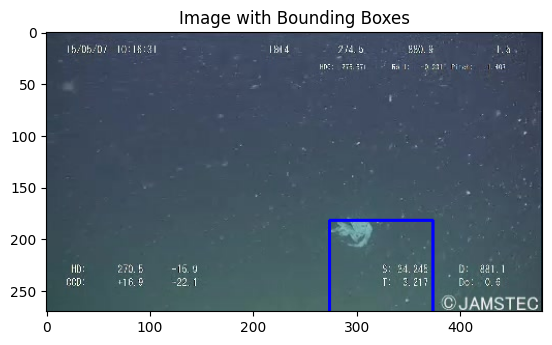

In [53]:
def visualize_bounding_boxes(image_path, bounding_boxes):
    """
    Visualize bounding boxes on an image.
    """
    image = cv2.imread(image_path)
    for (x, y, w, h) in bounding_boxes:
        top_left = (int(x), int(y))
        bottom_right = (int(x + w), int(y + h))
        cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)  # Draw rectangle

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image with Bounding Boxes")
    plt.show()

# Example visualization
sample_image_path = "dataset/original_data/images/vid_000002_frame0000017.jpg"
visualize_bounding_boxes(sample_image_path, bounding_boxes)


### YOLO Conversion

In [46]:
def convert_to_yolo_format(image_path, bounding_boxes):
    """
    Convert bounding boxes to YOLO format (normalized coordinates).
    """
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    yolo_annotations = []
    for (x, y, w, h) in bounding_boxes:
        x_center = (x + w / 2) / width
        y_center = (y + h / 2) / height
        box_width = w / width
        box_height = h / height
        yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")
    return yolo_annotations

def save_yolo_annotations(output_path, image_name, yolo_annotations):
    """
    Save YOLO annotations to a .txt file.
    """
    txt_file = os.path.join(output_path, image_name.replace(".jpg", ".txt"))
    with open(txt_file, 'w') as file:
        file.write("\n".join(yolo_annotations))

# Example usage
yolo_labels_path = "dataset/labels"
os.makedirs(yolo_labels_path, exist_ok=True)

yolo_annotations = convert_to_yolo_format(sample_image_path, bounding_boxes)
save_yolo_annotations(yolo_labels_path, "vid_000002_frame0000013.jpg", yolo_annotations)

### Save YOLO Annotations

In [34]:
def save_yolo_annotations(output_path, image_name, yolo_annotations):
    """
    Save YOLO annotations to a .txt file.
    """
    txt_file = os.path.join(output_path, image_name.replace(".jpg", ".txt"))
    with open(txt_file, 'w') as file:
        file.write("\n".join(yolo_annotations))

### Process the Entire Dataset

In [35]:
# Process the dataset
for json_file in os.listdir(annotations_path):
    json_path = os.path.join(annotations_path, json_file)
    image_name = json_file.replace(".json", "")
    image_path = os.path.join(images_path, image_name)

    # Parse JSON to extract bounding boxes
    bounding_boxes = parse_json_annotations_fallback(json_path)
    print(f"Bounding boxes for {json_file}: {bounding_boxes}")

    # Convert bounding boxes to YOLO format
    if bounding_boxes:
        yolo_annotations = convert_to_yolo_format(image_path, bounding_boxes)

        # Save YOLO annotations
        save_yolo_annotations(yolo_labels_path, image_name, yolo_annotations)
        print(f"Saved YOLO annotations for {image_name}")
    else:
        print(f"No bounding boxes found for {json_file}")


Bounding boxes for vid_000002_frame0000013.jpg.json: [(254, 76, 50, 50)]
Saved YOLO annotations for vid_000002_frame0000013.jpg
Bounding boxes for vid_000002_frame0000014.jpg.json: [(261, 101, 50, 50)]
Saved YOLO annotations for vid_000002_frame0000014.jpg
Bounding boxes for vid_000002_frame0000015.jpg.json: [(267, 137, 50, 50)]
Saved YOLO annotations for vid_000002_frame0000015.jpg
Bounding boxes for vid_000002_frame0000016.jpg.json: [(273, 164, 50, 50)]
Saved YOLO annotations for vid_000002_frame0000016.jpg
Bounding boxes for vid_000002_frame0000017.jpg.json: [(274, 182, 50, 50)]
Saved YOLO annotations for vid_000002_frame0000017.jpg
Bounding boxes for vid_000002_frame0000018.jpg.json: [(268, 186, 50, 50)]
Saved YOLO annotations for vid_000002_frame0000018.jpg
Bounding boxes for vid_000002_frame0000019.jpg.json: [(262, 184, 50, 50)]
Saved YOLO annotations for vid_000002_frame0000019.jpg
Bounding boxes for vid_000002_frame0000020.jpg.json: [(241, 194, 50, 50)]
Saved YOLO annotations f

### Visualize Sample Image with Bounding Boxes

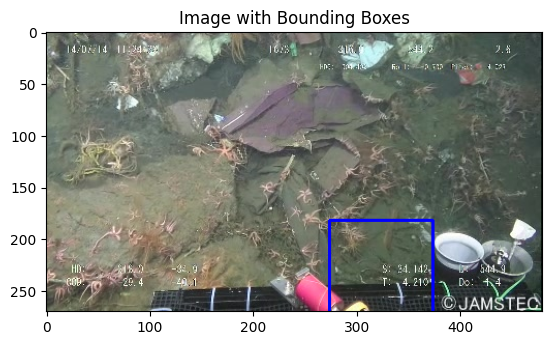

In [50]:
def visualize_bounding_boxes(image_path, bounding_boxes):
    """
    Visualize bounding boxes on an image.
    """
    image = cv2.imread(image_path)
    for (x, y, w, h) in bounding_boxes:
        top_left = (int(x), int(y))
        bottom_right = (int(x + w), int(y + h))
        cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)  # Draw rectangle

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image with Bounding Boxes")
    plt.show()

# Example visualization
sample_image_path = os.path.join(images_path, "vid_000555_frame0000041.jpg")
visualize_bounding_boxes(sample_image_path, bounding_boxes)
